In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

# Loading the Data

In [10]:
data = pd.read_csv('processed_data/fraud_data_processed.csv', index_col=0)
data.head(2)

,category,amt,gender,lat,long,city_pop,merch_lat,merch_long,is_fraud,customer_age
0,personal_care,2.86,M,33.9659,-80.9355,333497,33.986391,-81.200714,0,52.0
1,personal_care,29.84,F,40.3207,-110.4360,302,39.450498,-109.960431,0,30.0


In [11]:
data.dtypes

category         object
amt             float64
gender           object
lat             float64
long            float64
city_pop          int64
merch_lat       float64
merch_long      float64
is_fraud          int64
customer_age    float64
dtype: object

(array([1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(1, 0, 'amt'),
  Text(2, 0, 'lat'),
  Text(3, 0, 'long'),
  Text(4, 0, 'city_pop'),
  Text(5, 0, 'merch_lat'),
  Text(6, 0, 'merch_long'),
  Text(7, 0, 'is_fraud'),
  Text(8, 0, 'customer_age')])

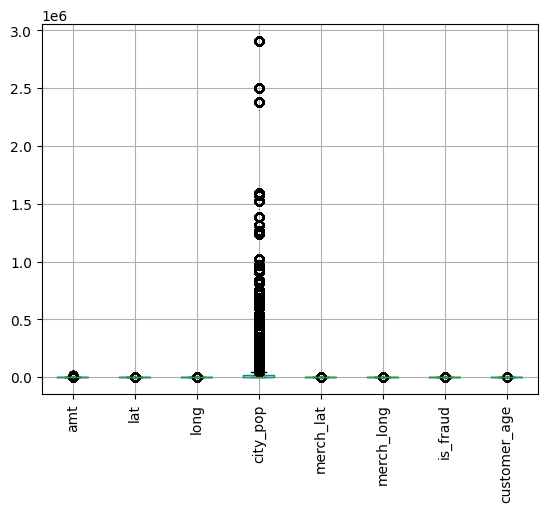

In [15]:
data.boxplot()
plt.xticks(rotation=90)

In [22]:
no_outliers = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'customer_age']

preprocessor = make_column_transformer(
    (RobustScaler(),['city_pop']),
    (MinMaxScaler(), no_outliers),
    (OneHotEncoder(), make_column_selector(dtype_include=['object'])), remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('robustscaler', RobustScaler(), ['city_pop']),
                                ('minmaxscaler', MinMaxScaler(),
                                 ['amt', 'lat', 'long', 'city_pop', 'merch_lat',
                                  'merch_long', 'customer_age']),
                                ('onehotencoder', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x298b7ed10>)])

In [18]:
X = data.drop(columns=['is_fraud'])
y = data['is_fraud']
print(X.shape)
print(y.shape)

(555719, 9)
(555719,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(y_train.shape)

(389003, 9)
(389003,)


In [23]:
X_train_processed = preprocessor.fit_transform(X_train)

In [24]:
X_test_processed = preprocessor.transform(X_test)

In [25]:
print(X_train_processed.shape)
print(X_test_processed.shape)

(389003, 24)
(166716, 24)


# Modeling

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [44]:
X_train_processed = torch.tensor(X_train_processed).float().to(device)
y_train_processed = torch.tensor(y_train).float().to(device)

/var/folders/vn/13psflc51r9239vr17gr6rxw0000gn/T/ipykernel_33739/3296485047.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_processed = torch.tensor(X_train_processed).float().to(device)


ValueError: could not determine the shape of object type 'Series'

In [37]:
class ModelDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [41]:
ds = ModelDataset(X_train_processed, y_train)

dataloader = DataLoader(ds, batch_size=32, shuffle=True)

In [40]:
item = iter(dataloader)
next(item)

KeyError: 361581

In [35]:
model = nn.Sequential(
    nn.Linear(24, 40),
    nn.ReLU(),
    nn.Linear(40, 60),
    nn.ReLU(),
    nn.Linear(60,20),
    nn.ReLU(),
    nn.Linear(20, 1),
    nn.Sigmoid()
).to(device)

In [28]:
model

Sequential(
  (0): Linear(in_features=24, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=60, bias=True)
  (3): ReLU()
  (4): Linear(in_features=60, out_features=20, bias=True)
  (5): ReLU()
  (6): Linear(in_features=20, out_features=1, bias=True)
  (7): Sigmoid()
)